train.csv :
·      area_type: The type of the house area feature 'total_sqft' specifies.
·      availability: The availability date or availability status of the property.
·      location: The locality of the property in Bengaluru city.
·      size: The size of the housing property in BHK (or Bedrooms etc.,).
·      society: The name of the Apartment. This name is encrypted for confidentiality.
·      total_sqft: The 'area_type' area of the property.
·      bath: Number of bathrooms available in the house.
·      balcony: Number of balcony/balconies the house has.
·      price: Price of the housing property in Lakhs. (target feature)
 
The `test.csv` dataset contains similar information to train.csv but does not disclose the “price” feature. The price has to be predicted through your model.
 
avg_rent.csv :
·      location : The locality of the property in the bengaluru city.
·      avg_2bhk_rent : Average rent of two BHK flat in that location
 
 
dist_from_city_centre.csv : 
·      location : The locality of the property in the bengaluru city.
·      dist_from_city : Distance of the location from city center

In [1631]:
import numpy as np
import re
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

%matplotlib inline
import collections
import itertools
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#print(statsmodels.__version__)
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample

from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import rmse

import warnings

warnings.filterwarnings("ignore")

In [1632]:
df = pd.read_csv("train.csv")
df_rent = pd.read_csv("avg_rent.csv")
df_dist = pd.read_csv("dist_from_city_centre.csv")
df_test = pd.read_csv("test.csv")
df_rent.head()

,location,avg_2bhk_rent
0,Krishnarajapura,11954
1,Sarjapur,45000
2,Whitefield Hope Farm Junction,26370
3,Devanahalli,17302
4,Whitefield,14981


In [1633]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [1634]:
locator = Nominatim(user_agent="myGeocoder")
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode)

df['location_city'] = df['location'].apply(lambda x: str(x) + ", Bangalore, Karnataka, India")
df.head()

KeyboardInterrupt: 

In [ ]:
d

In [ ]:
df.head()

In [1500]:
df_test.isna().sum()

ID                 0
area_type          0
availability       0
location           0
size               2
society         1074
total_sqft         0
bath               8
balcony          105
dtype: int64

In [1501]:
df.isna().sum()

ID                 0
area_type          0
availability       0
location           1
size              14
society         4428
total_sqft         0
bath              65
balcony          504
price              0
dtype: int64

In [1502]:
df_t = df.copy()
df_t['loc_soc'] = df_t['location'] + "-" + df_t['society']
train_loc_soc = set(df_t['loc_soc'].unique())
df_test_t = df_test.copy()
df_test_t['loc_soc'] = df_test_t['location'] + "-" + df_test_t['society']
test_loc_soc = set(df_test_t['loc_soc'].unique())

print(len(train_loc_soc), len(test_loc_soc), len(train_loc_soc.intersection(test_loc_soc)))
print(len(test_loc_soc) - len(train_loc_soc.intersection(test_loc_soc)))

2400 961 627
334


In [1503]:
test_soc = set(df_test.society.unique())
train_soc = set(df.society.unique())
common_soc = train_soc.intersection(test_soc)
print(len(train_soc.intersection(test_soc) - test_soc))
len(train_soc), len(test_soc), len(train_soc.intersection(test_soc))


0


(2365, 956, 632)

This concludes that all the societies in Test are in Train

In [1504]:
# Encoding Availability
df['availability'] = df['availability'].apply(lambda x: 1 if x=="Ready To Move" else 0)

## PRELIMINARY CLEAN-UPS

In [1505]:
df.balcony.value_counts()

2.0    4069
1.0    3894
3.0    1342
0.0     847
Name: balcony, dtype: int64

<AxesSubplot:xlabel='size', ylabel='balcony'>

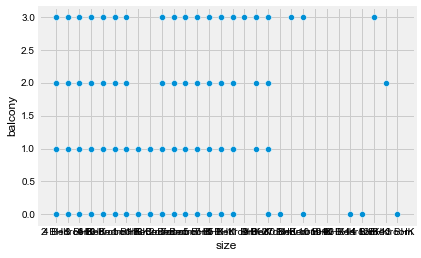

In [1506]:
sns.scatterplot(x=df['size'], y=df.balcony)

In [1507]:
df[df['balcony'].isna()]

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
6,6,Super built-up Area,0,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,7,Super built-up Area,1,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
9,9,Plot Area,1,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00
34,34,Built-up Area,1,Kasturi Nagar,3 BHK,Kantsce,1925,3.0,NaN,125.00
40,40,Built-up Area,1,Murugeshpalya,2 BHK,Gentson,1296,2.0,NaN,81.00
...,...,...,...,...,...,...,...,...,...,...
10560,10560,Built-up Area,1,HSR Layout,5 Bedroom,NaN,4200,5.0,NaN,245.00
10561,10561,Super built-up Area,1,Thubarahalli,3 BHK,Asnts a,1540,3.0,NaN,90.00
10593,10593,Built-up Area,1,Marathahalli,4 Bedroom,Vemes H,3090,4.0,NaN,350.00
10634,10634,Plot Area,0,Rajankunte,NaN,NaN,1575,NaN,NaN,31.11


In [1508]:
# Dropping the ID column for its redundancy
# Getting rid of society to avoid imputing huge amount of null values
# Availability doesnt much determine the price of a house
df.drop(columns=["ID", "society", "area_type"], axis=1, inplace=True)

In [1509]:
df.isna().sum()

availability      0
location          1
size             14
total_sqft        0
bath             65
balcony         504
price             0
dtype: int64

In [1510]:
df['location'].value_counts()

Whitefield                  433
Sarjapur  Road              303
Electronic City             234
Kanakpura Road              217
Thanisandra                 178
                           ... 
Aishwarya Crystal Layout      1
Sector 3 HSR Layout           1
T C Palya main Road           1
S R Layout                    1
5th block Koramangala         1
Name: location, Length: 1197, dtype: int64

In [1511]:
# Replacing 1 NaN in location with mode of the dataset
df['location'] = df['location'].fillna('Whitefield')

In [1512]:
# Replacing Size with highest occuring categorical value
df['size'].value_counts()

2 BHK         4146
3 BHK         3425
4 Bedroom      659
4 BHK          478
3 Bedroom      446
1 BHK          435
2 Bedroom      281
5 Bedroom      232
6 Bedroom      154
1 Bedroom       88
8 Bedroom       65
7 Bedroom       65
5 BHK           50
9 Bedroom       41
6 BHK           21
1 RK            13
7 BHK           12
10 Bedroom       8
9 BHK            7
8 BHK            3
11 Bedroom       2
10 BHK           2
11 BHK           2
14 BHK           1
43 Bedroom       1
19 BHK           1
16 BHK           1
27 BHK           1
13 BHK           1
12 Bedroom       1
Name: size, dtype: int64

In [1513]:
df['size'] = df['size'].fillna('2 BHK')

# Creating 3 additional columns
df['hall'] = np.nan
df['kitchen'] = np.nan
df['room_count'] = np.nan

In [1514]:
# We are splitting the values in size into 3 columns:  Hall | Kitchen | Room_Count
# This is important as 1RK is different from 1 BHK


def split_size(df, index, size):
    df.loc[index, 'room_count'] = str(size).split()[0]
    if str(size).split()[1] == "BHK":
        df.loc[index, 'hall'] = 1
        df.loc[index, 'kitchen'] = 1
    elif str(size).split()[1] == "RK":
        df.loc[index, 'hall'] = 0
        df.loc[index, 'kitchen'] = 1
    else:
        df.loc[index, 'hall'] = 0
        df.loc[index, 'kitchen'] = 0
    


In [1515]:
for index, row in df.iterrows():
    split_size(df, index, df.loc[index, 'size'])

df.head()

,availability,location,size,total_sqft,bath,balcony,price,hall,kitchen,room_count
0,0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,1.0,1.0,2
1,1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,0.0,0.0,4
2,1,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,1.0,1.0,3
3,1,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,1.0,1.0,3
4,1,Kothanur,2 BHK,1200,2.0,1.0,51.00,1.0,1.0,2


In [1516]:
df[['price','room_count']] = df[['price','room_count']].astype(float)

In [1517]:
# For all rows where room_count is greater than 10, lets drop them
# Also our Test data has only rooms till 10.
df = df[df['room_count']<=10]
df = df[df['size']!='1 RK']
df.shape

(10632, 10)

In [1518]:
df['bath'].median()

2.0

In [1519]:
median_bath_df = pd.DataFrame(df.groupby('size')['bath'].median())
median_bath_df

,bath
size,
1 BHK,1.0
1 Bedroom,1.0
10 BHK,12.0
10 Bedroom,10.0
2 BHK,2.0
2 Bedroom,2.0
3 BHK,3.0
3 Bedroom,3.0
4 BHK,4.0


In [1520]:
# Filling the NaN values in bath with corresponding median for the respective room size
for index, row in df.iterrows():
    if np.isnan(df.loc[index, 'bath']):
        df.loc[index, 'bath'] = median_bath_df.loc[df.loc[index,'size']].values[0]

In [1521]:
# Replacing all the NaN values in balcony witht the median of the subgroup based on number of rooms
balcony_df = pd.DataFrame(df.groupby('size')['balcony'].median())
balcony_df

,balcony
size,
1 BHK,1.0
1 Bedroom,0.0
10 BHK,NaN
10 Bedroom,3.0
2 BHK,1.0
2 Bedroom,1.0
3 BHK,2.0
3 Bedroom,1.0
4 BHK,2.0


In [1522]:
# We can see that for properties with higher the bedroom size dont have bath. And most of our NaN are for bedrooms
# > 10. Setting all NaN as 0
balcony_df.fillna(0, inplace=True)

In [1523]:
# Filling NaN values with corresponding mean for the respective room size
for index, row in df.iterrows():
    if np.isnan(df.loc[index, 'balcony']):
        df.loc[index, 'balcony'] = balcony_df.loc[df.loc[index,'size']].values[0]
df.head()

,availability,location,size,total_sqft,bath,balcony,price,hall,kitchen,room_count
0,0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,1.0,1.0,2.0
1,1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,0.0,0.0,4.0
2,1,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,1.0,1.0,3.0
3,1,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,1.0,1.0,3.0
4,1,Kothanur,2 BHK,1200,2.0,1.0,51.00,1.0,1.0,2.0


In [1524]:
df.isna().sum()

availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
hall            0
kitchen         0
room_count      0
dtype: int64

In [1525]:
df.dropna(inplace=True)
df.isna().sum()

availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
hall            0
kitchen         0
room_count      0
dtype: int64

In [1526]:
df.shape

(10632, 10)

In [1527]:
df['size'].value_counts()

2 BHK         4160
3 BHK         3425
4 Bedroom      659
4 BHK          478
3 Bedroom      446
1 BHK          435
2 Bedroom      281
5 Bedroom      232
6 Bedroom      154
1 Bedroom       88
7 Bedroom       65
8 Bedroom       65
5 BHK           50
9 Bedroom       41
6 BHK           21
7 BHK           12
10 Bedroom       8
9 BHK            7
8 BHK            3
10 BHK           2
Name: size, dtype: int64

In [1528]:
# Finding all the rows in total_sqft which contain different units
df['total_sqft_is_alphanumeric'] = list(map(lambda x: re.search(r'[a-zA-Z]',x) != None, df['total_sqft']))
df.loc[df['total_sqft_is_alphanumeric']==True].head()

,availability,location,size,total_sqft,bath,balcony,price,hall,kitchen,room_count,total_sqft_is_alphanumeric
410,1,Kengeri,1 BHK,34.46Sq. Meter,1.0,0.0,18.5,1.0,1.0,1.0,True
648,1,Arekere,9 Bedroom,4125Perch,9.0,2.0,265.0,0.0,0.0,9.0,True
775,1,Basavanagara,1 BHK,1000Sq. Meter,2.0,1.0,93.0,1.0,1.0,1.0,True
872,1,Singapura Village,2 BHK,1100Sq. Yards,2.0,1.0,45.0,1.0,1.0,2.0,True
1019,0,Marathi Layout,1 Bedroom,5.31Acres,1.0,0.0,110.0,0.0,0.0,1.0,True


We can see that there are multiple units which are used here:
SqMeter/Acres/SqYards/Grounds/Cents/Guntha/Perch

Using calculators from https://housing.com/calculators/ground-to-square-feet
* 1 Ground =  2400.352024 sq.ft
* 1 Perch = 272.25 sq.ft
* 1 acre = 43560.00001 sq.ft
* 1 Guntha = 1089 sq.ft
* 1 sq.yards = 9.000000878 sq.ft
* 1 sq.meters = 10.76391042 sq.ft
* 1 Cents = 435.56 sq.ft

In [1529]:
def return_in_sq_ft(value, units):
    units = units.lower()
    value=float(value)
    if units=="grounds":
        return value*2400.352024
    elif units=="perch":
        return value*272.25
    elif units=="acres":
        return value*43560.00001
    elif units=="guntha":
        return value*1089
    elif units=="sq.yards":
        return value*9.000000878
    elif units=="sq.meter":
        return value*10.76391042
    elif units=="cents":
        return value*435.56
    else:
        print(f"{units} not FOUND")

def units_in_sq_ft(value):
    if re.search(r'[a-zA-Z]',value) != None:
        
        s_arr = re.findall(r'\d+[.]?\d*|[A-Za-z.]+', value)
        return return_in_sq_ft(s_arr[0], "".join(s_arr[1:]))
    elif value.find("-")!=-1:
        return (float(value.split("-")[0])+float(value.split("-")[1]))/2
    else:
        return float(value)

df["total_sqft"] = df["total_sqft"].apply(units_in_sq_ft)

In [1530]:
df.drop(columns=["total_sqft_is_alphanumeric"], inplace=True)

In [1531]:
df.room_count.value_counts()

2.0     4441
3.0     3871
4.0     1137
1.0      523
5.0      282
6.0      175
7.0       77
8.0       68
9.0       48
10.0      10
Name: room_count, dtype: int64

total_sqft
1100.0 1680.0
price
50.0 120.0
room_count
2.0 3.0


<AxesSubplot:>

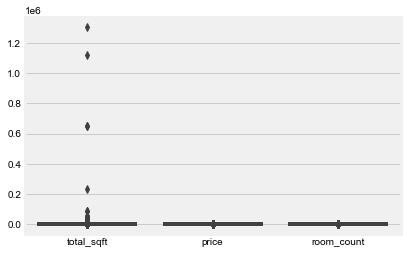

In [1532]:
# Getting rid of the outliers from originally numeric column
df_o = df[['total_sqft','price','room_count']]
for col in df_o.columns:
    tempdata = df_o.sort_values(by=col)[col]
    print(col)
    q1,q3 = tempdata.quantile([0.25,0.75])
    print(q1,q3)
    IQR = q1-q3
    lr = q1-1.5*IQR
    ur = q3+1.5*IQR
    # Replacing the values 
    df_o[col].apply(lambda x: x if x <= ur else ur)
    df_o[col].apply(lambda x: x if x >= lr else lr)

sns.boxplot(data=df_o)

In [1533]:
df_o.head()

,total_sqft,price,room_count
0,1056.0,39.07,2.0
1,2600.0,120.00,4.0
2,1440.0,62.00,3.0
3,1521.0,95.00,3.0
4,1200.0,51.00,2.0


In [1534]:
df.drop(columns=['total_sqft','price','room_count'], inplace=True)
df = pd.concat([df, df_o], axis=1)
df.head()

,availability,location,size,bath,balcony,hall,kitchen,total_sqft,price,room_count
0,0,Electronic City Phase II,2 BHK,2.0,1.0,1.0,1.0,1056.0,39.07,2.0
1,1,Chikka Tirupathi,4 Bedroom,5.0,3.0,0.0,0.0,2600.0,120.00,4.0
2,1,Uttarahalli,3 BHK,2.0,3.0,1.0,1.0,1440.0,62.00,3.0
3,1,Lingadheeranahalli,3 BHK,3.0,1.0,1.0,1.0,1521.0,95.00,3.0
4,1,Kothanur,2 BHK,2.0,1.0,1.0,1.0,1200.0,51.00,2.0


### Adding per square-feet price

In [1535]:
df['price_per_square_ft'] = (df['price']*1000000)/df['total_sqft']
df.head()

,availability,location,size,bath,balcony,hall,kitchen,total_sqft,price,room_count,price_per_square_ft
0,0,Electronic City Phase II,2 BHK,2.0,1.0,1.0,1.0,1056.0,39.07,2.0,36998.106061
1,1,Chikka Tirupathi,4 Bedroom,5.0,3.0,0.0,0.0,2600.0,120.00,4.0,46153.846154
2,1,Uttarahalli,3 BHK,2.0,3.0,1.0,1.0,1440.0,62.00,3.0,43055.555556
3,1,Lingadheeranahalli,3 BHK,3.0,1.0,1.0,1.0,1521.0,95.00,3.0,62458.908613
4,1,Kothanur,2 BHK,2.0,1.0,1.0,1.0,1200.0,51.00,2.0,42500.000000


In [1536]:
# Adding another categorical variable for big and small rooms
df['room_size'] = np.nan

for index, row in df.iterrows():
    if df.loc[index,'total_sqft']/df.loc[index,'room_count'] < 300:
        df.loc[index, 'room_size'] = 0
    else:
        df.loc[index, 'room_size'] = 1

df.head()

,availability,location,size,bath,balcony,hall,kitchen,total_sqft,price,room_count,price_per_square_ft,room_size
0,0,Electronic City Phase II,2 BHK,2.0,1.0,1.0,1.0,1056.0,39.07,2.0,36998.106061,1.0
1,1,Chikka Tirupathi,4 Bedroom,5.0,3.0,0.0,0.0,2600.0,120.00,4.0,46153.846154,1.0
2,1,Uttarahalli,3 BHK,2.0,3.0,1.0,1.0,1440.0,62.00,3.0,43055.555556,1.0
3,1,Lingadheeranahalli,3 BHK,3.0,1.0,1.0,1.0,1521.0,95.00,3.0,62458.908613,1.0
4,1,Kothanur,2 BHK,2.0,1.0,1.0,1.0,1200.0,51.00,2.0,42500.000000,1.0


### Finding all the unique Locations

In [1537]:
# Erasing the outliers from each group of locations
def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_square_ft)
        st=np.std(subdf.price_per_square_ft)
        reduced_df=subdf[(subdf.price_per_square_ft>(m-3*st))& (subdf.price_per_square_ft<(m+3*st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df_2=remove_pps_outliers(df)
df_2.shape

(10048, 12)

Text(0, 0.5, 'Count')

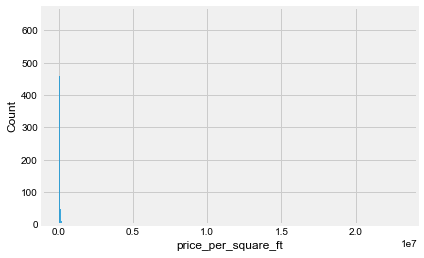

In [1538]:
sns.histplot(df_2['price_per_square_ft'])
plt.ylabel('Count')

Text(0, 0.5, 'Count')

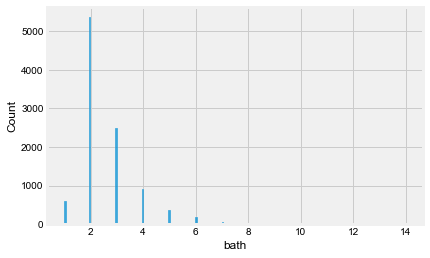

In [1539]:
sns.histplot(df_2['bath'])
plt.ylabel('Count')

In [1540]:
df_2.head()

,availability,location,size,bath,balcony,hall,kitchen,total_sqft,price,room_count,price_per_square_ft,room_size
0,1,Devarabeesana Halli,2 BHK,2.0,1.0,1.0,1.0,1100.0,70.0,2.0,63636.363636,1.0
1,1,Devarabeesana Halli,3 BHK,3.0,2.0,1.0,1.0,1672.0,150.0,3.0,89712.918660,1.0
2,1,Devarabeesana Halli,3 BHK,3.0,3.0,1.0,1.0,1750.0,149.0,3.0,85142.857143,1.0
3,1,Devarabeesana Halli,3 BHK,3.0,2.0,1.0,1.0,1670.0,160.0,3.0,95808.383234,1.0
4,1,Devarabeesana Halli,3 BHK,3.0,2.0,1.0,1.0,1750.0,150.0,3.0,85714.285714,1.0


## CHECKING FOR OUTLIERS

<AxesSubplot:xlabel='price'>

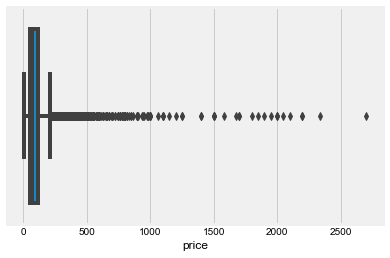

In [1541]:
# First checking the target column
sns.boxplot(df_2['price'])

We are keeping the outliers for price, as we might be needed to predict such cases in Test Data

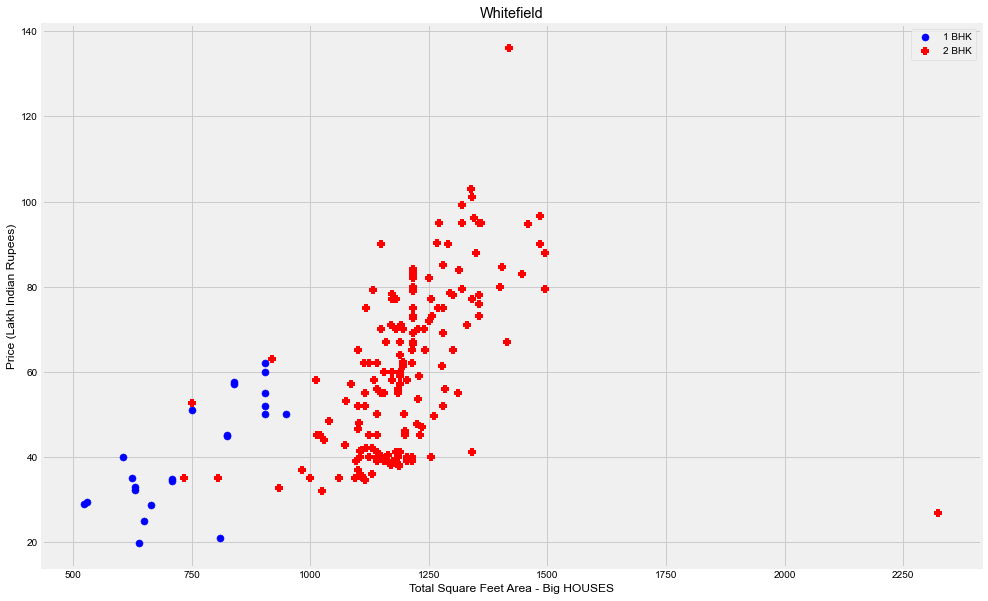

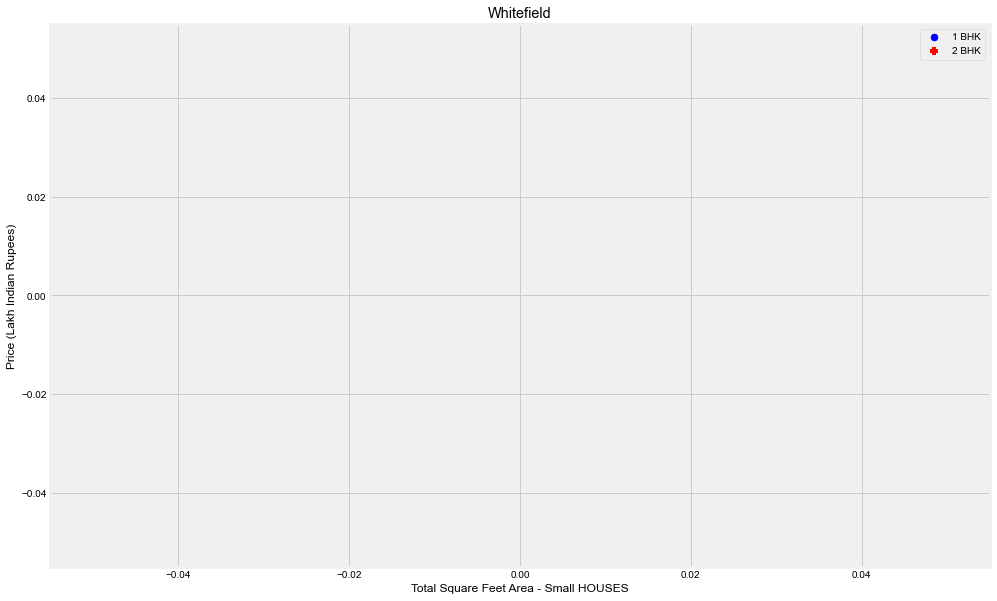

In [1542]:
def plot_multiple_size_with_price(size_1, size_2, location, df):
    bhk_first = df[(df['location']==location) & (df['room_count']==size_1)]
    big_bhk_first = bhk_first[bhk_first['room_size']==1]
    small_bhk_first = bhk_first[bhk_first['room_size']==0]
    bhk_second = df[(df['location']==location) & (df['room_count']==size_2)]
    big_bhk_second = bhk_second[bhk_second['room_size']==1]
    small_bhk_second = bhk_second[bhk_second['room_size']==0]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(big_bhk_first.total_sqft,big_bhk_first.price,color='blue',label=str(size_1)+" BHK", s=50)
    plt.scatter(big_bhk_second.total_sqft,big_bhk_second.price,marker='+',color='red',label=str(size_2)+" BHK", s=50)
    
    plt.xlabel("Total Square Feet Area - Big HOUSES")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    plt.show()
    
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(small_bhk_first.total_sqft,small_bhk_first.price,color='blue',label=str(size_1)+" BHK", s=50)
    plt.scatter(small_bhk_second.total_sqft,small_bhk_second.price,marker='+',color='red',label=str(size_2)+" BHK", s=50)
    
    plt.xlabel("Total Square Feet Area - Small HOUSES")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    plt.show()
    
    

plot_multiple_size_with_price(1,2, "Whitefield", df_2)

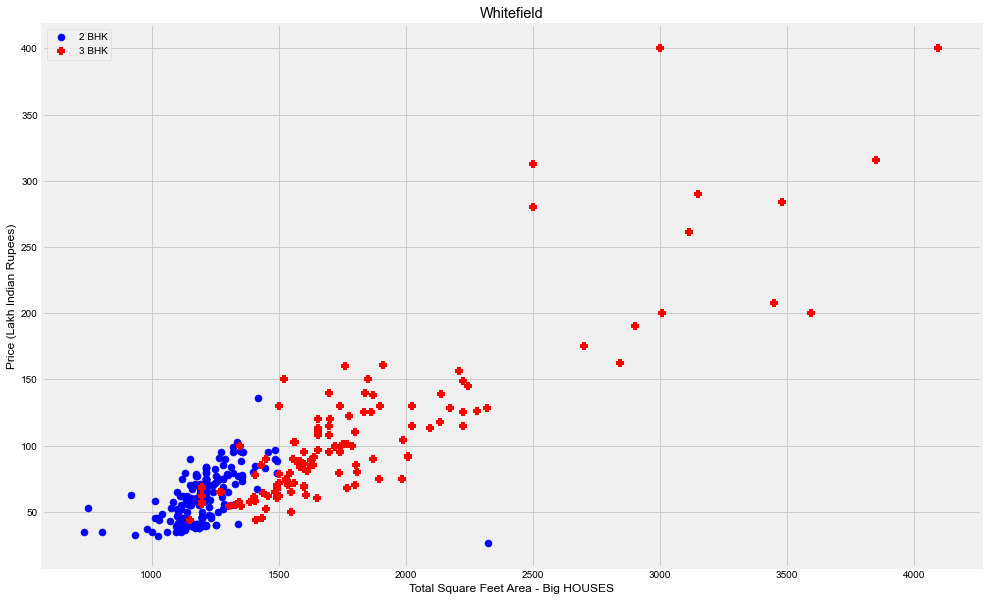

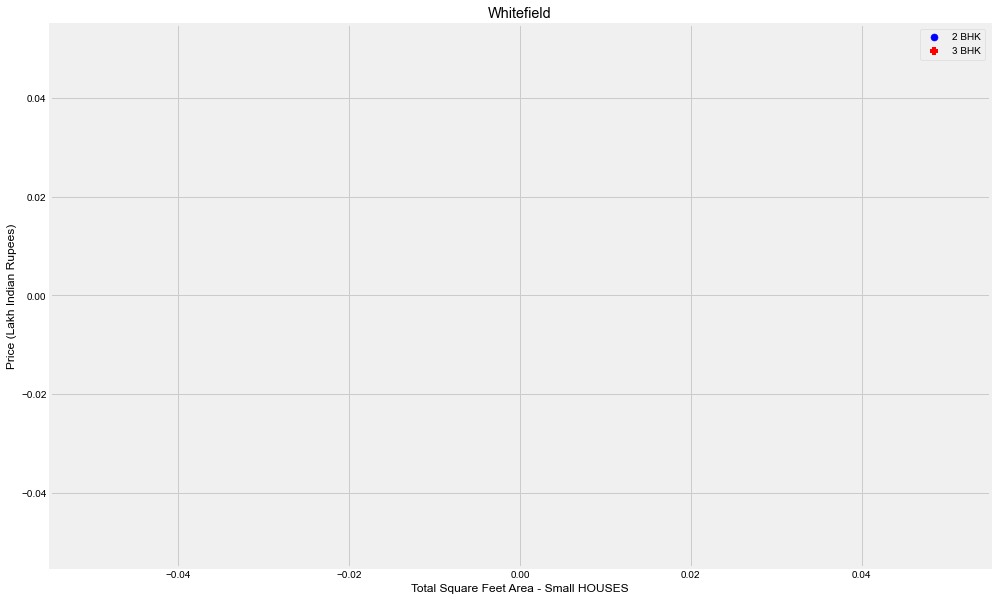

In [1543]:
plot_multiple_size_with_price(2,3, "Whitefield", df_2)

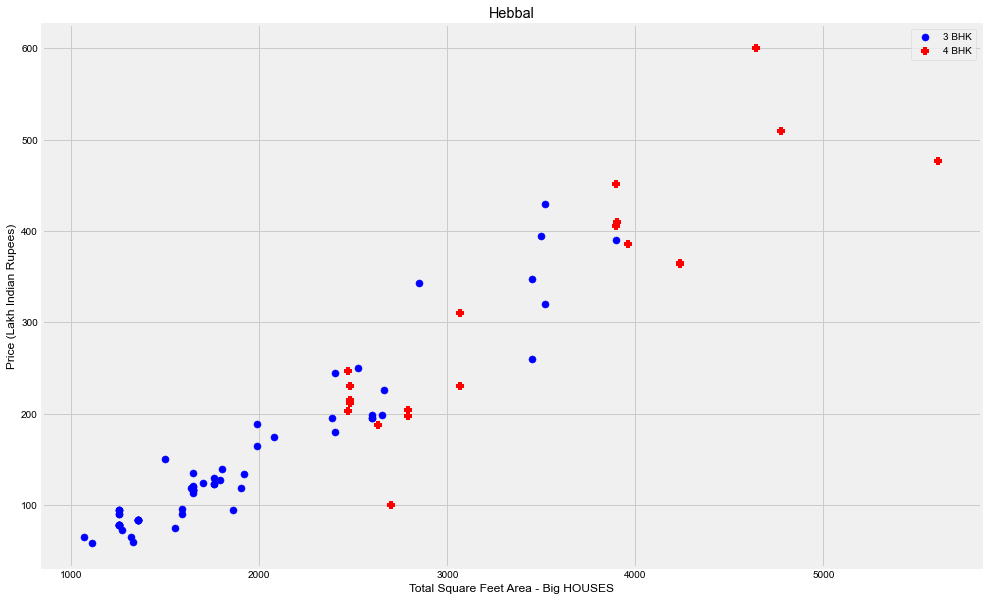

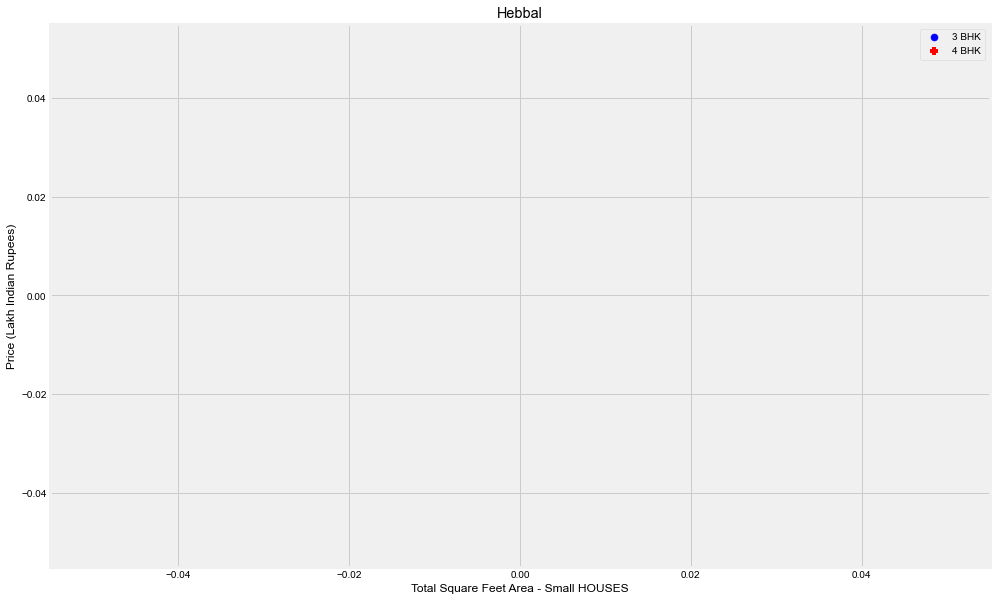

In [1544]:
plot_multiple_size_with_price(3,4, "Hebbal", df_2)

In a location, when the square feet increases as well as the number of rooms increase, still certain houses with lower space and room number are priced higher than larger houses. Those rows need to be removed. We will find the mean price of a house of a particular size. And if the per square foot rate of the house is less than mean of smaller size house, then we will get rid of it.

In [1545]:
def remove_irregularly_priced_houses(df):
    exclusion_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for size, size_df in location_df.groupby(['room_count']):
            bhk_stats[size] = {
                'mean': np.mean(size_df.price_per_square_ft),
                'std': np.std(size_df.price_per_square_ft),
                'count': size_df.shape[0]
            }
        for size, size_df in location_df.groupby('size'):
            stats = bhk_stats.get(size-1)
            if stats and stats['count'] > 5:
                exclusion_indices = np.append(exclusion_indices, size_df[size_df.price_per_square_ft<(stats['mean'])].index.values)
    return df.drop(exclusion_indices, axis='index')

# df_3 = remove_irregularly_priced_houses(df_2)
df_3 = df_2.copy()
df_3.shape

(10048, 12)

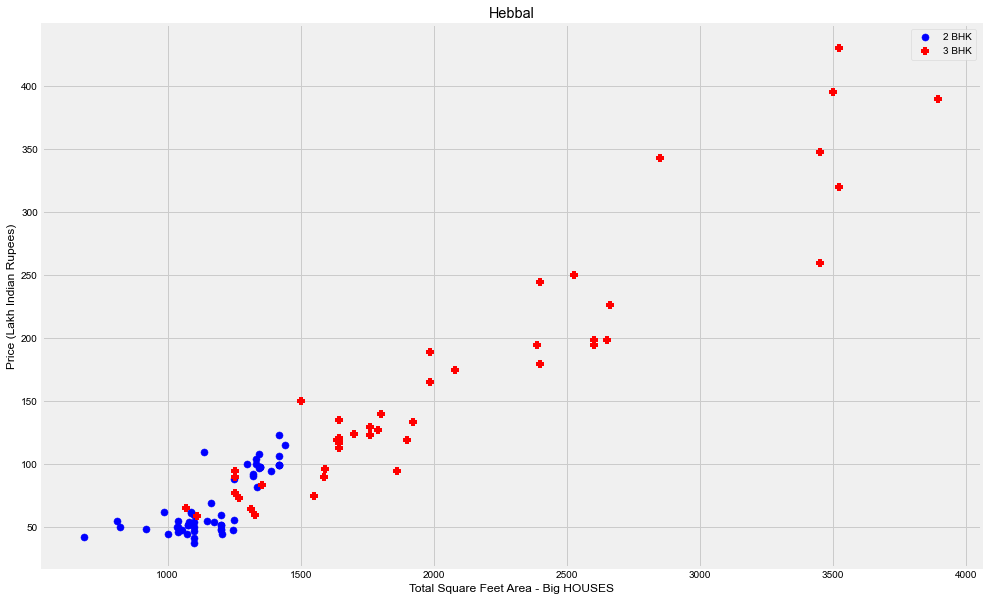

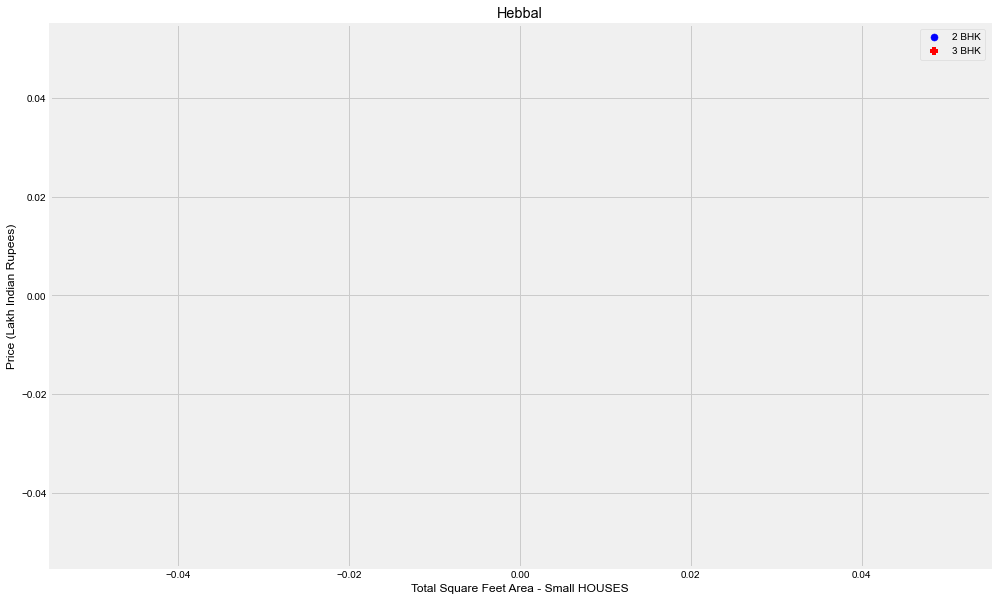

In [1546]:
plot_multiple_size_with_price(2,3, "Hebbal", df_3)

We can see that the number of 3 BHKs with lesser price-per-square-feet as compared to 2 BHK are removed.

## Doing PREPROCESSING

In [1547]:
from sklearn import preprocessing

df_2_num = df_2.select_dtypes(include=np.number)
# Dropping the future target column from Scaling
df_2_num.drop(columns=['price'], inplace=True)
min_max_scaler = preprocessing.MinMaxScaler()
df_2_num_scaled = min_max_scaler.fit_transform(df_2_num.values)
scaled_df = pd.DataFrame(df_2_num_scaled, columns=df_2_num.columns, index=df_2_num.index)
scaled_df.head()

,availability,bath,balcony,hall,kitchen,total_sqft,room_count,price_per_square_ft,room_size
0,1.0,0.076923,0.333333,1.0,1.0,0.000975,0.111111,0.002757,1.0
1,1.0,0.153846,0.666667,1.0,1.0,0.001484,0.222222,0.003890,1.0
2,1.0,0.153846,1.000000,1.0,1.0,0.001554,0.222222,0.003692,1.0
3,1.0,0.153846,0.666667,1.0,1.0,0.001483,0.222222,0.004155,1.0
4,1.0,0.153846,0.666667,1.0,1.0,0.001554,0.222222,0.003716,1.0


In [1548]:
scaled_df.room_count.value_counts()

0.111111    4300
0.222222    3707
0.333333    1013
0.000000     499
0.444444     239
0.555556     131
0.666667      59
0.777778      50
0.888889      41
1.000000       9
Name: room_count, dtype: int64

In [1549]:
df_2_normalized = pd.concat([df_2.select_dtypes(exclude=np.number), scaled_df, df_2['price']], axis=1)
df_2_normalized.head()

,location,size,availability,bath,balcony,hall,kitchen,total_sqft,room_count,price_per_square_ft,room_size,price
0,Devarabeesana Halli,2 BHK,1.0,0.076923,0.333333,1.0,1.0,0.000975,0.111111,0.002757,1.0,70.0
1,Devarabeesana Halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001484,0.222222,0.003890,1.0,150.0
2,Devarabeesana Halli,3 BHK,1.0,0.153846,1.000000,1.0,1.0,0.001554,0.222222,0.003692,1.0,149.0
3,Devarabeesana Halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001483,0.222222,0.004155,1.0,160.0
4,Devarabeesana Halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001554,0.222222,0.003716,1.0,150.0


In [1550]:
df_2_normalized['location'] = df_2_normalized['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_test['location'] = df_test['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_dist['location'] = df_dist['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))

set_locations_train_data = set(df_2_normalized['location'].unique())
set_locations_test_data = set(df_test['location'].unique())
set_location_dist = set(df_dist['location'].unique())
set_location_in_both_train_test_data = set_locations_test_data.intersection(set_locations_train_data)

In [1551]:
print(len(set_locations_train_data))

738


In [1552]:
print(len(set_locations_test_data))

669


In [1553]:
print(len(set_location_in_both_train_test_data))

494


In order to have the same number of columns in both train and test data, we need to set any location which is not present in both train and test data as other

In [1554]:
# Setting the location which are in train as well as in test and setting the other locations as other
df_2_normalized['location'] = df_2_normalized['location'].apply(lambda x: x if x in set_location_in_both_train_test_data else 'other')

print(f"{len(df_2_normalized['location'].unique())}")

495


In [1555]:
df_dist["location"] = df_dist["location"].apply(lambda x: x.lower().strip().replace('  ', ' '))
len(set(df_dist["location"].unique()).intersection(set_location_in_both_train_test_data))

427

In [1556]:
# Setting the location distance from CITY Centre as well in df_2
df_3 = df_2_normalized.copy()

In [1557]:
df_3.head()

,location,size,availability,bath,balcony,hall,kitchen,total_sqft,room_count,price_per_square_ft,room_size,price
0,devarabeesana halli,2 BHK,1.0,0.076923,0.333333,1.0,1.0,0.000975,0.111111,0.002757,1.0,70.0
1,devarabeesana halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001484,0.222222,0.003890,1.0,150.0
2,devarabeesana halli,3 BHK,1.0,0.153846,1.000000,1.0,1.0,0.001554,0.222222,0.003692,1.0,149.0
3,devarabeesana halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001483,0.222222,0.004155,1.0,160.0
4,devarabeesana halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001554,0.222222,0.003716,1.0,150.0


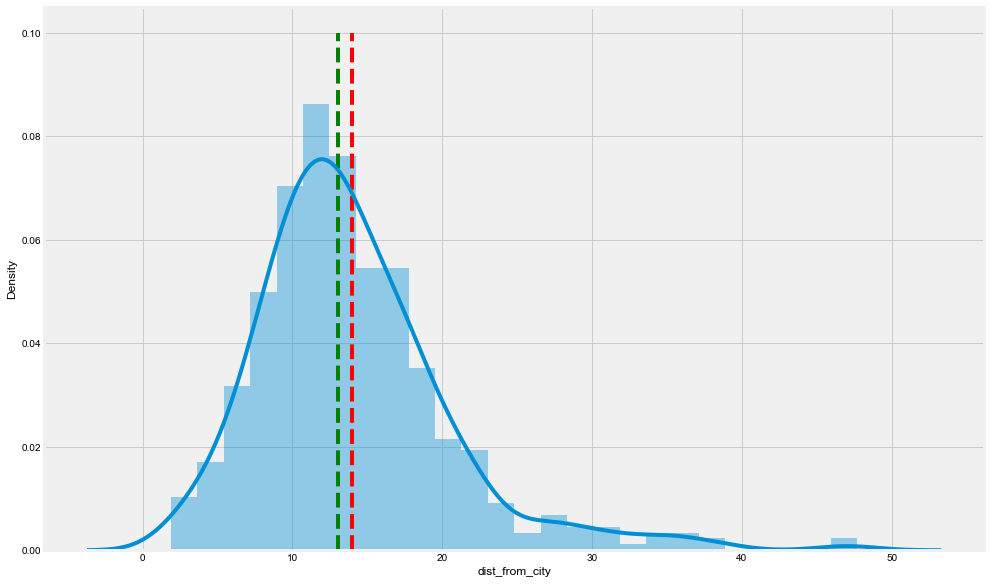

In [1558]:
sns.distplot(df_dist['dist_from_city'], kde=True)
plt.vlines(x=df_dist['dist_from_city'].mean(), ymin=0, ymax=0.1, colors='r', linestyles='dashed')
plt.vlines(x=df_dist['dist_from_city'].median(), ymin=0, ymax=0.1, colors='g', linestyles='dashed')

In [1559]:
df_3.isna().sum()

location               0
size                   0
availability           0
bath                   0
balcony                0
hall                   0
kitchen                0
total_sqft             0
room_count             0
price_per_square_ft    0
room_size              0
price                  0
dtype: int64

In [1560]:
def min_max_scale(x, min_val, max_val):
    return (x - min_val)/(max_val - min_val)

def get_dist(location):
    if location in df_dist['location'].unique():
        return df_dist.loc[df_dist['location'] == location]['dist_from_city'].values[0]
    else:
        return df_dist['dist_from_city'].median()

In [1561]:
df_3['dist'] = df_3['location'].apply(get_dist)
# Doing min-max scaling on the dist column which is remaining
min_val = df_3['dist'].min()
max_val = df_3['dist'].max()

df_3['dist'] = df_3['dist'].apply(min_max_scale, args=(min_val,max_val))
df_3.head()

,location,size,availability,bath,balcony,hall,kitchen,total_sqft,room_count,price_per_square_ft,room_size,price,dist
0,devarabeesana halli,2 BHK,1.0,0.076923,0.333333,1.0,1.0,0.000975,0.111111,0.002757,1.0,70.0,0.272926
1,devarabeesana halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001484,0.222222,0.003890,1.0,150.0,0.272926
2,devarabeesana halli,3 BHK,1.0,0.153846,1.000000,1.0,1.0,0.001554,0.222222,0.003692,1.0,149.0,0.272926
3,devarabeesana halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001483,0.222222,0.004155,1.0,160.0,0.272926
4,devarabeesana halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001554,0.222222,0.003716,1.0,150.0,0.272926


In [1562]:
# Optimizing number of features in OLS model
from itertools import combinations

X_num = df_3.select_dtypes(include=np.number)
X_num.drop(columns=["price", "availability", "price_per_square_ft", "hall", "kitchen", "room_count", "room_size"], inplace=True)
out = df_3["price"]

column_list = X_num.columns
interactions = list(combinations(column_list, 1))

interaction_dict = {}
for interaction in interactions:
    print(interaction)
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])
column_list

('bath',)
('balcony',)
('total_sqft',)
('dist',)
0.2602926400360964 ('dist',)


Index(['bath', 'balcony', 'total_sqft', 'dist'], dtype='object')

In [1563]:
column_list = X_num.columns
interactions = list(combinations(column_list, 2))

interaction_dict = {}
for interaction in interactions:
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])
column_list

0.2697542556863264 ('bath', 'dist')
0.26451588412457616 ('bath', 'balcony')
0.26277174876158305 ('bath', 'total_sqft')
0.2619030655552935 ('balcony', 'dist')
0.2605577934364631 ('total_sqft', 'dist')


Index(['bath', 'balcony', 'total_sqft', 'dist'], dtype='object')

In [1564]:
# Optimizing number of features in OLS model
column_list = X_num.columns
interactions = list(combinations(column_list, 3))

interaction_dict = {}
for interaction in interactions:
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]] * int_2_cols[interaction[2]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])
column_list

0.2624650597088565 ('bath', 'total_sqft', 'dist')
0.2617618704559598 ('bath', 'balcony', 'total_sqft')
0.2617508221570244 ('bath', 'balcony', 'dist')
0.2604624823554178 ('balcony', 'total_sqft', 'dist')


Index(['bath', 'balcony', 'total_sqft', 'dist'], dtype='object')

In [1565]:
# Taking combination of 4 columns
column_list = X_num.columns
interactions = list(combinations(column_list, 4))

interaction_dict = {}
for interaction in interactions:
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]] * int_2_cols[interaction[2]] * int_2_cols[interaction[3]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])
column_list

0.2617425059287831 ('bath', 'balcony', 'total_sqft', 'dist')


Index(['bath', 'balcony', 'total_sqft', 'dist'], dtype='object')

In [1566]:
# Taking combination of 5 columns
column_list = X_num.columns
interactions = list(combinations(column_list, 5))

interaction_dict = {}
for interaction in interactions:
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]] * int_2_cols[interaction[2]] * int_2_cols[interaction[3]] * int_2_cols[interaction[4]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])


In [1567]:
df_3.isna().sum()

location               0
size                   0
availability           0
bath                   0
balcony                0
hall                   0
kitchen                0
total_sqft             0
room_count             0
price_per_square_ft    0
room_size              0
price                  0
dist                   0
dtype: int64

In [1568]:
df_3['interaction'] = df_3['bath'] * df_3['dist']

In [1569]:
df_3.head()

,location,size,availability,bath,balcony,hall,kitchen,total_sqft,room_count,price_per_square_ft,room_size,price,dist,interaction
0,devarabeesana halli,2 BHK,1.0,0.076923,0.333333,1.0,1.0,0.000975,0.111111,0.002757,1.0,70.0,0.272926,0.020994
1,devarabeesana halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001484,0.222222,0.003890,1.0,150.0,0.272926,0.041989
2,devarabeesana halli,3 BHK,1.0,0.153846,1.000000,1.0,1.0,0.001554,0.222222,0.003692,1.0,149.0,0.272926,0.041989
3,devarabeesana halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001483,0.222222,0.004155,1.0,160.0,0.272926,0.041989
4,devarabeesana halli,3 BHK,1.0,0.153846,0.666667,1.0,1.0,0.001554,0.222222,0.003716,1.0,150.0,0.272926,0.041989


In [1570]:
# Dummy encoding for location
dummies = pd.get_dummies(data=df_3.drop(columns=['location']), columns=['size'])
# dummies.drop(columns=['location_other'], inplace=True)
dummies.drop(columns=["hall","kitchen","room_count"], inplace=True)

# Dropping a column which is not present in Test Data : 1 RK
dummies.head()

,availability,bath,balcony,total_sqft,price_per_square_ft,room_size,price,dist,interaction,size_1 BHK,...,size_5 BHK,size_5 Bedroom,size_6 BHK,size_6 Bedroom,size_7 BHK,size_7 Bedroom,size_8 BHK,size_8 Bedroom,size_9 BHK,size_9 Bedroom
0,1.0,0.076923,0.333333,0.000975,0.002757,1.0,70.0,0.272926,0.020994,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.153846,0.666667,0.001484,0.003890,1.0,150.0,0.272926,0.041989,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.153846,1.000000,0.001554,0.003692,1.0,149.0,0.272926,0.041989,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.153846,0.666667,0.001483,0.004155,1.0,160.0,0.272926,0.041989,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.153846,0.666667,0.001554,0.003716,1.0,150.0,0.272926,0.041989,0,...,0,0,0,0,0,0,0,0,0,0


In [1571]:
df_4 = dummies.copy()
df_4.head()

,availability,bath,balcony,total_sqft,price_per_square_ft,room_size,price,dist,interaction,size_1 BHK,...,size_5 BHK,size_5 Bedroom,size_6 BHK,size_6 Bedroom,size_7 BHK,size_7 Bedroom,size_8 BHK,size_8 Bedroom,size_9 BHK,size_9 Bedroom
0,1.0,0.076923,0.333333,0.000975,0.002757,1.0,70.0,0.272926,0.020994,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.153846,0.666667,0.001484,0.003890,1.0,150.0,0.272926,0.041989,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.153846,1.000000,0.001554,0.003692,1.0,149.0,0.272926,0.041989,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.153846,0.666667,0.001483,0.004155,1.0,160.0,0.272926,0.041989,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.153846,0.666667,0.001554,0.003716,1.0,150.0,0.272926,0.041989,0,...,0,0,0,0,0,0,0,0,0,0


In [1572]:
X=df_4.drop(columns=['price','price_per_square_ft'], axis='columns')
X.head()

,availability,bath,balcony,total_sqft,room_size,dist,interaction,size_1 BHK,size_1 Bedroom,size_10 BHK,...,size_5 BHK,size_5 Bedroom,size_6 BHK,size_6 Bedroom,size_7 BHK,size_7 Bedroom,size_8 BHK,size_8 Bedroom,size_9 BHK,size_9 Bedroom
0,1.0,0.076923,0.333333,0.000975,1.0,0.272926,0.020994,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.153846,0.666667,0.001484,1.0,0.272926,0.041989,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.153846,1.000000,0.001554,1.0,0.272926,0.041989,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.153846,0.666667,0.001483,1.0,0.272926,0.041989,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.153846,0.666667,0.001554,1.0,0.272926,0.041989,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1573]:
y = df_4['price']

In [1574]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

model_1=LinearRegression()
model_1.fit(X_train,y_train)
model_1.score(X_test,y_test)

0.3728767252266847

In [1575]:
model_1.predict(X)

array([ 55.25023596, 114.83625239, 123.35927135, ..., 108.05791991,
       113.27432345, 159.17795535])

In [1576]:
y

0         70.00
1        150.00
2        149.00
3        160.00
4        150.00
          ...  
10043     61.99
10044     62.00
10045     48.00
10046     55.00
10047     78.00
Name: price, Length: 10048, dtype: float64

In [1577]:
rmse(model_1.predict(X), y)

104.5544840384231

In [1578]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        y_pred=gs.predict(X)
        gs_rmse = rmse(y,y_pred)
        scores.append({
            'model': algo_name,
            'shape': X.shape,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_,
            'rmse': gs_rmse
        })

    return pd.DataFrame(scores,columns=['model','shape', 'best_score','best_params','rmse'])

find_best_model_using_gridsearchcv(X,y)


,model,shape,best_score,best_params,rmse
0,linear_regression,"(10048, 27)",0.375187,{'normalize': True},104.371454
1,lasso,"(10048, 27)",0.335581,"{'alpha': 1, 'selection': 'cyclic'}",108.680808
2,decision_tree,"(10048, 27)",0.332186,"{'criterion': 'friedman_mse', 'splitter': 'best'}",7.326994


In [1579]:
res_df = pd.DataFrame(columns=['model','best_score','best_params','rmse'])
# Creating the best model separately

cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
gs =  GridSearchCV(
    DecisionTreeRegressor(), 
    {
        'criterion' : ['mse','friedman_mse'],
        'splitter': ['best','random']
    },
    cv=cv, 
    return_train_score=False
)
gs.fit(X,y)

y_pred=gs.predict(X)
gs_rmse = rmse(y,y_pred)
res_df.append({
    "model": "DecisionTreeRegressor",
    "best_score": gs.best_score_,
    "best_params": gs.best_params_,
    "rmse": gs_rmse
}, ignore_index=True)

,model,best_score,best_params,rmse
0,DecisionTreeRegressor,0.374796,"{'criterion': 'mse', 'splitter': 'best'}",7.326994


In [1580]:
# Trying Grid Search CV with ElasticNet
hyp_param = {'alpha':[0.01, 0.09, 0.1, 0.2], 'l1_ratio':[0.98, 0.99, 0.999, 1, 2]}
enet = ElasticNet(normalize=True)
hyper_model = GridSearchCV(estimator=enet, param_grid=hyp_param, cv=5, scoring='r2')

enet_model = hyper_model.fit(X, y)
print(f"Best Hyper Parameter: {enet_model.best_params_}")
print(f"Best Score: {enet_model.best_score_}")

Best Hyper Parameter: {'alpha': 0.01, 'l1_ratio': 1}
Best Score: 0.36543645503900635


In [1581]:
enet_rmse = rmse(enet_model.predict(X),y)
enet_rmse

104.58982714095839

In [1582]:
from sklearn.ensemble import RandomForestRegressor

x_train,x_test,y_train,y_test=train_test_split(X,y, test_size=0.2)
RFC = RandomForestRegressor(n_estimators=20, n_jobs=-1, oob_score=True)
RFC.fit(x_train,y_train)
y_test_pred = RFC.predict(x_test)
rmse(y_test, y_test_pred)

68.71322314422343

In [1583]:
from sklearn.model_selection import GridSearchCV

x=X

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=10)

param={'max_depth':[5,10,15,20,30],'min_samples_leaf':[10,15,20,50,100]}

gs_rfc=GridSearchCV(estimator=RFC,param_grid=param,cv=4,n_jobs=-1,scoring='r2')

gs_rfc.fit(x_train,y_train)

gs_rfc.best_estimator_
gs_best=gs_rfc.best_estimator_

gs_best.fit(x_train,y_train)

train_pred=gs_best.predict(x_train)

test_pred=gs_best.predict(x_test)


print('RMSE for train:',np.sqrt(mean_squared_error(y_train,train_pred)))
print('RMSE for test:',np.sqrt(mean_squared_error(y_test,test_pred)))


print('r2_score for train:',r2_score(y_train,train_pred))
print('r2_score for test:',r2_score(y_test,test_pred))

RMSE for train: 69.15066992294102
RMSE for test: 62.17259106816475
r2_score for train: 0.7416429617526207
r2_score for test: 0.6744426311586398


In [1584]:
from sklearn.ensemble import HistGradientBoostingRegressor

est = HistGradientBoostingRegressor().fit(X, y)
y_pred = est.predict(X)
rmse_hgbr = rmse(y_pred, y)
print(est.score(X, y), rmse_hgbr)

0.7789809671609316 62.803772541814425


## PROCESSING THE TEST-DATA

In [1585]:
df_test.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony
0,0,Super built-up Area,Ready To Move,chamrajpet,2 BHK,NaN,650,1.0,1.0
1,1,Super built-up Area,Ready To Move,7th phase jp nagar,3 BHK,SrncyRe,1370,2.0,1.0
2,2,Super built-up Area,Ready To Move,whitefield,3 BHK,AjhalNa,1725,3.0,2.0
3,3,Built-up Area,Ready To Move,jalahalli,2 BHK,NaN,1000,2.0,0.0
4,4,Plot Area,Ready To Move,tc palaya,1 Bedroom,NaN,1350,1.0,0.0


In [1586]:
df_test['availability'] = df_test['availability'].apply(lambda x: 1 if x=="Ready To Move" else 0)

In [1587]:
df_test_1 = df_test.drop(columns=["ID", "society", "area_type"])
df_test_1.isna().sum()

availability      0
location          0
size              2
total_sqft        0
bath              8
balcony         105
dtype: int64

In [1588]:
df_test_1['location'] = df_test_1['location'].fillna('Whitefield')

In [1589]:
df_test_1['size'] = df_test_1['size'].fillna('2 BHK')

# Creating 3 additional columns
df_test_1['hall'] = np.nan
df_test_1['kitchen'] = np.nan
df_test_1['room_count'] = np.nan

for index, row in df_test_1.iterrows():
    split_size(df_test_1, index, df_test_1.loc[index, 'size'])

In [1590]:
df_test_1.head()

,availability,location,size,total_sqft,bath,balcony,hall,kitchen,room_count
0,1,chamrajpet,2 BHK,650,1.0,1.0,1.0,1.0,2
1,1,7th phase jp nagar,3 BHK,1370,2.0,1.0,1.0,1.0,3
2,1,whitefield,3 BHK,1725,3.0,2.0,1.0,1.0,3
3,1,jalahalli,2 BHK,1000,2.0,0.0,1.0,1.0,2
4,1,tc palaya,1 Bedroom,1350,1.0,0.0,0.0,0.0,1


In [1591]:
df_test_1.isna().sum()

availability      0
location          0
size              0
total_sqft        0
bath              8
balcony         105
hall              0
kitchen           0
room_count        0
dtype: int64

In [1592]:
# Filling the NaN values in bath with corresponding median for the respective room size
for index, row in df_test_1.iterrows():
    if np.isnan(df_test_1.loc[index, 'bath']):
        df_test_1.loc[index, 'bath'] = median_bath_df.loc[df_test_1.loc[index,'size']].values[0]


In [1593]:
# Filling NaN values with corresponding mean for the respective room size
for index, row in df_test_1.iterrows():
    if np.isnan(df_test_1.loc[index, 'balcony']):
        if df_test_1.loc[index,'size'] in balcony_df.index:
            df_test_1.loc[index, 'balcony'] = balcony_df.loc[df_test_1.loc[index,'size']].values[0]
        else:
            df_test_1.loc[index, 'balcony'] = 0

In [1594]:
df_test_1["total_sqft"] = df_test_1["total_sqft"].apply(units_in_sq_ft)

In [1595]:
df_test_1.isna().sum()

availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
hall            0
kitchen         0
room_count      0
dtype: int64

<AxesSubplot:xlabel='size', ylabel='bath'>

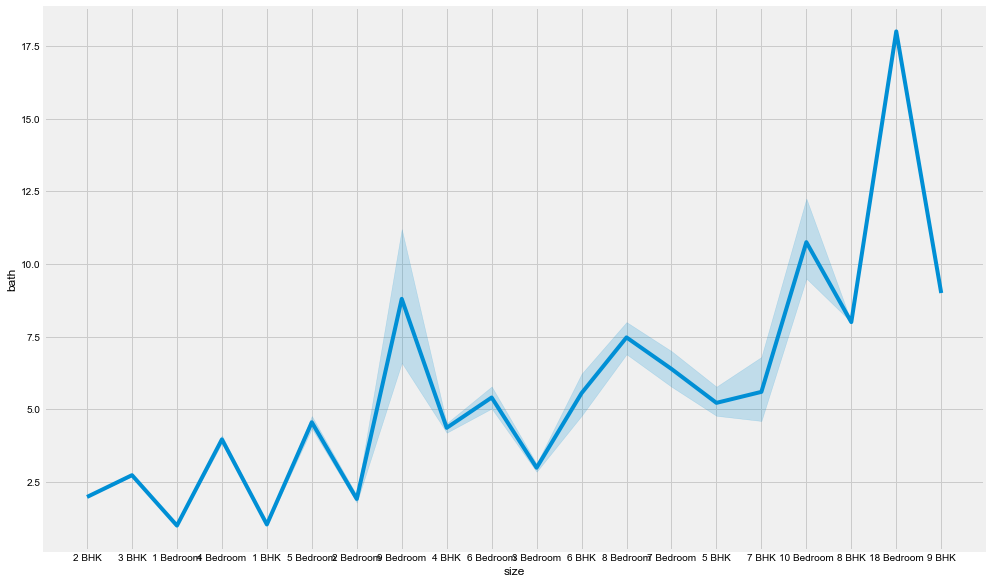

In [1596]:
sns.lineplot(x=df_test_1['size'], y=df_test_1['bath'])

In [1597]:
df_test_1[['total_sqft','room_count']] = df_test_1[['total_sqft','room_count']].astype(float)
df_test_1['room_size'] = np.nan
for index, row in df_test_1.iterrows():
    if df_test_1.loc[index,'total_sqft']/df_test_1.loc[index,'room_count'] < 300:
        df_test_1.loc[index, 'room_size'] = 0
    else:
        df_test_1.loc[index, 'room_size'] = 1

In [1598]:
df_test_1.head()

,availability,location,size,total_sqft,bath,balcony,hall,kitchen,room_count,room_size
0,1,chamrajpet,2 BHK,650.0,1.0,1.0,1.0,1.0,2.0,1.0
1,1,7th phase jp nagar,3 BHK,1370.0,2.0,1.0,1.0,1.0,3.0,1.0
2,1,whitefield,3 BHK,1725.0,3.0,2.0,1.0,1.0,3.0,1.0
3,1,jalahalli,2 BHK,1000.0,2.0,0.0,1.0,1.0,2.0,1.0
4,1,tc palaya,1 Bedroom,1350.0,1.0,0.0,0.0,0.0,1.0,1.0


In [1599]:
df_test_1['dist'] = df_test_1['location'].apply(get_dist)
# Doing min-max scaling on the dist column which is remaining
# min_val = df_test_1['dist'].min()
# max_val = df_test_1['dist'].max()

# df_test_1['dist'] = df_test_1['dist'].apply(min_max_scale, args=(min_val,max_val))
df_test_1.head()

,availability,location,size,total_sqft,bath,balcony,hall,kitchen,room_count,room_size,dist
0,1,chamrajpet,2 BHK,650.0,1.0,1.0,1.0,1.0,2.0,1.0,6.7
1,1,7th phase jp nagar,3 BHK,1370.0,2.0,1.0,1.0,1.0,3.0,1.0,11.0
2,1,whitefield,3 BHK,1725.0,3.0,2.0,1.0,1.0,3.0,1.0,17.3
3,1,jalahalli,2 BHK,1000.0,2.0,0.0,1.0,1.0,2.0,1.0,16.6
4,1,tc palaya,1 Bedroom,1350.0,1.0,0.0,0.0,0.0,1.0,1.0,12.2


In [1600]:
df_test_num = df_test_1.select_dtypes(include=np.number)
min_max_scaler = preprocessing.MinMaxScaler()
df_test_num_scaled = min_max_scaler.fit_transform(df_test_num.values)
scaled_test_df = pd.DataFrame(df_test_num_scaled, columns=df_test_num.columns, index=df_test_num.index)

In [1601]:
scaled_test_df.head()

,availability,total_sqft,bath,balcony,hall,kitchen,room_count,room_size,dist
0,1.0,0.002258,0.000000,0.333333,1.0,1.0,0.058824,1.0,0.104803
1,1.0,0.005013,0.058824,0.333333,1.0,1.0,0.117647,1.0,0.198690
2,1.0,0.006372,0.117647,0.666667,1.0,1.0,0.117647,1.0,0.336245
3,1.0,0.003597,0.058824,0.000000,1.0,1.0,0.058824,1.0,0.320961
4,1.0,0.004937,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.224891


In [1602]:
df_test_normalized = pd.concat([df_test_1.select_dtypes(exclude=np.number), scaled_test_df], axis=1)
df_test_normalized.head()

,location,size,availability,total_sqft,bath,balcony,hall,kitchen,room_count,room_size,dist
0,chamrajpet,2 BHK,1.0,0.002258,0.000000,0.333333,1.0,1.0,0.058824,1.0,0.104803
1,7th phase jp nagar,3 BHK,1.0,0.005013,0.058824,0.333333,1.0,1.0,0.117647,1.0,0.198690
2,whitefield,3 BHK,1.0,0.006372,0.117647,0.666667,1.0,1.0,0.117647,1.0,0.336245
3,jalahalli,2 BHK,1.0,0.003597,0.058824,0.000000,1.0,1.0,0.058824,1.0,0.320961
4,tc palaya,1 Bedroom,1.0,0.004937,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.224891


In [1603]:
df_test_normalized["location"] = df_test_normalized["location"].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_test_normalized['location'] = df_test_normalized['location'].apply(lambda x: x if x in set_location_in_both_train_test_data else 'other')

In [1604]:
len(df_test_normalized['location'].unique())

495

In [1605]:
df_test_normalized.isna().sum()

location        0
size            0
availability    0
total_sqft      0
bath            0
balcony         0
hall            0
kitchen         0
room_count      0
room_size       0
dist            0
dtype: int64

In [1606]:
df_test_normalized['interaction'] = df_test_normalized['bath'] * df_test_normalized['dist']

In [1607]:
df_test_normalized.head()

,location,size,availability,total_sqft,bath,balcony,hall,kitchen,room_count,room_size,dist,interaction
0,chamrajpet,2 BHK,1.0,0.002258,0.000000,0.333333,1.0,1.0,0.058824,1.0,0.104803,0.000000
1,7th phase jp nagar,3 BHK,1.0,0.005013,0.058824,0.333333,1.0,1.0,0.117647,1.0,0.198690,0.011688
2,whitefield,3 BHK,1.0,0.006372,0.117647,0.666667,1.0,1.0,0.117647,1.0,0.336245,0.039558
3,jalahalli,2 BHK,1.0,0.003597,0.058824,0.000000,1.0,1.0,0.058824,1.0,0.320961,0.018880
4,tc palaya,1 Bedroom,1.0,0.004937,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.224891,0.000000


In [1608]:
dummies = pd.get_dummies(data=df_test_normalized.drop(columns=['location']), columns=['size'])
# dummies.drop(columns=['location_other'], inplace=True)
dummies.drop(columns=["hall","kitchen","room_count"], inplace=True)
dummies.head()

,availability,total_sqft,bath,balcony,room_size,dist,interaction,size_1 BHK,size_1 Bedroom,size_10 Bedroom,...,size_5 BHK,size_5 Bedroom,size_6 BHK,size_6 Bedroom,size_7 BHK,size_7 Bedroom,size_8 BHK,size_8 Bedroom,size_9 BHK,size_9 Bedroom
0,1.0,0.002258,0.000000,0.333333,1.0,0.104803,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.005013,0.058824,0.333333,1.0,0.198690,0.011688,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.006372,0.117647,0.666667,1.0,0.336245,0.039558,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.003597,0.058824,0.000000,1.0,0.320961,0.018880,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.004937,0.000000,0.000000,1.0,0.224891,0.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [1609]:
df_test_2 = dummies.copy()
df_test_2.head()

,availability,total_sqft,bath,balcony,room_size,dist,interaction,size_1 BHK,size_1 Bedroom,size_10 Bedroom,...,size_5 BHK,size_5 Bedroom,size_6 BHK,size_6 Bedroom,size_7 BHK,size_7 Bedroom,size_8 BHK,size_8 Bedroom,size_9 BHK,size_9 Bedroom
0,1.0,0.002258,0.000000,0.333333,1.0,0.104803,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.005013,0.058824,0.333333,1.0,0.198690,0.011688,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.006372,0.117647,0.666667,1.0,0.336245,0.039558,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.003597,0.058824,0.000000,1.0,0.320961,0.018880,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.004937,0.000000,0.000000,1.0,0.224891,0.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [1610]:
df_test_2.shape

(2664, 27)

In [1611]:
df_test_normalized['size'].unique()

array(['2 BHK', '3 BHK', '1 Bedroom', '4 Bedroom', '1 BHK', '5 Bedroom',
       '2 Bedroom', '9 Bedroom', '4 BHK', '6 Bedroom', '3 Bedroom',
       '6 BHK', '8 Bedroom', '7 Bedroom', '5 BHK', '7 BHK', '10 Bedroom',
       '8 BHK', '18 Bedroom', '9 BHK'], dtype=object)

In [1612]:
df_3['size'].unique()

array(['2 BHK', '3 BHK', '2 Bedroom', '1 BHK', '3 Bedroom', '4 BHK',
       '4 Bedroom', '5 Bedroom', '8 Bedroom', '7 Bedroom', '10 Bedroom',
       '6 BHK', '6 Bedroom', '5 BHK', '9 BHK', '9 Bedroom', '1 Bedroom',
       '7 BHK', '8 BHK', '10 BHK'], dtype=object)

In [1613]:
set_size_test = set(df_test_normalized['size'].unique())
set_size_train = set(df_3['size'].unique())
print(len(set_size_test), len(set_size_train))
set_size_train_and_test = set_size_test.intersection(set_size_train)
print(len(set_size_train_and_test))

20 20
19


In [1614]:
df_test_normalized['size'].value_counts()

2 BHK         1055
3 BHK          885
4 Bedroom      167
4 BHK          113
1 BHK          103
3 Bedroom      101
5 Bedroom       65
2 Bedroom       48
6 Bedroom       37
8 Bedroom       19
7 Bedroom       18
1 Bedroom       17
6 BHK            9
5 BHK            9
7 BHK            5
9 Bedroom        5
10 Bedroom       4
8 BHK            2
9 BHK            1
18 Bedroom       1
Name: size, dtype: int64

## PREDICTION

### Using Linear Regression

In [1615]:
y_pred = model_1.predict(df_test_2)
df_lin_sol = pd.DataFrame()
df_lin_sol['price'] = y_test_pred
df_lin_sol.index.name='ID'
df_lin_sol.head(10)

,price
ID,
0,42.375333
1,17.475000
2,93.002500
3,113.200000
4,52.840000
5,53.318000
6,810.000000
7,114.350000
8,186.837500


In [1616]:
df_lin_sol.shape

(2010, 1)

In [1617]:
df_lin_sol.to_csv('lin_sol.csv')

In [1618]:
y_test_pred = gs.predict(df_test_2)
y_test_pred

array([175., 175., 217., ..., 150., 450., 150.])

In [1619]:
df_sol = pd.DataFrame()
df_sol['price'] = y_test_pred
df_sol.index.name='ID'
df_sol.head(10)

,price
ID,
0,175.0
1,175.0
2,217.0
3,55.0
4,35.0
5,175.0
6,217.0
7,217.0
8,150.0


In [1620]:
df_sol.to_csv("sol_gs.csv")

### Using Elastic Regression Model

In [1621]:
y_pred_enet = enet_model.predict(df_test_2)
y_pred_enet

array([ 48.40069273,  52.79071342,  55.03560348, ...,  30.91043146,
       131.9569636 ,  68.74064192])

In [1622]:
df_sol_enet = pd.DataFrame()
df_sol_enet['price'] = y_pred_enet
df_sol_enet.index.name='ID'
df_sol_enet.head(10)

,price
ID,
0,48.400693
1,52.790713
2,55.035603
3,-4.077370
4,54.791670
5,193.359303
6,68.200264
7,14.456376
8,33.219174


In [1623]:
df_sol_enet.to_csv("sol_enet.csv")

In [1624]:
df_sol_enet.shape

(2664, 1)

### Using Random Forest

In [1625]:
y_pred_RFC = RFC.predict(df_test_2)
df_sol_RFC = pd.DataFrame()
df_sol_RFC['price'] = y_pred_enet
df_sol_RFC.index.name='ID'
df_sol_RFC.to_csv("sol_RFC.csv")

In [1626]:
df_sol_RFC.head(10)

,price
ID,
0,48.400693
1,52.790713
2,55.035603
3,-4.077370
4,54.791670
5,193.359303
6,68.200264
7,14.456376
8,33.219174


### Using GridSearch CV on Random Forest

In [1627]:
y_pred_GS_CV = gs_best.predict(df_test_2)
df_sol_GS_CV = pd.DataFrame()
df_sol_GS_CV['price'] = y_pred_GS_CV
df_sol_GS_CV.index.name='ID'
df_sol_GS_CV.to_csv("sol_GS_CV.csv")

In [1628]:
df_sol_GS_CV.head(10)

,price
ID,
0,787.237050
1,595.215658
2,374.931034
3,62.583791
4,80.560590
5,625.248029
6,388.173359
7,510.561692
8,388.173359


In [1629]:
y_pred_hgbr = est.predict(df_test_2)
df_sol_hgbr = pd.DataFrame()
df_sol_hgbr['price'] = y_pred_hgbr
df_sol_hgbr.index.name='ID'
df_sol_hgbr.to_csv("sol_HGBR.csv")

In [1630]:
df_sol_hgbr.head(10)

,price
ID,
0,498.378893
1,453.926529
2,343.602853
3,37.338151
4,43.539758
5,695.889071
6,343.602853
7,470.617645
8,343.602853
